# Cybersecurity: Suspicious Web Threat Interactions

# Module Importing

In [35]:
%pip install pandas
%pip install seaborn
%pip install scikit-learn

import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
# Load the data into a DataFrame
data = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
# Display the first few rows of the DataFrame to understand its structure
data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


# Data Preprocessing

# 1. Data Cleaning

The dataset contains <span style="color: red; font-weight: bold;">282 entries</span> across <span style="color: blue; font-weight: bold;">16 columns</span>. There are no <span style="color: red; font-weight: bold;">null values</span> in any of the columns, which is <span style="color: red; font-weight: bold;">good news for data integrity</span>. However, let's proceed with the following data cleaning tasks:


1. <span style="color: red; font-weight: bold;"> Removing Duplicate Rows :</span> Even though all entries appear non-null, there may still be duplicate entries that should be removed to prevent skewing our analysis.
2. <span style="color: red; font-weight: bold;"> Correcting Data Types :</span> Some columns such as `creation_time`, `end_time`, and `time` should ideally be in datetime format for any time series analysis or operations that involve time intervals.
3. <span style="color: red; font-weight: bold;"> Standardize Text Data :</span> Ensuring consistency in how text data is formatted can be important, particularly if you're going to perform text-based operations or integrations.

The data has been cleaned with the following steps implemented:

1. <span style="color: red; font-weight: bold;"> Duplicate Rows :</span> No duplicate rows were found, so the dataset remains with 282 entries.
2. <span style="color: red; font-weight: bold;"> Data Types :</span> The `creation_time`, `end_time`, and `time` columns have been successfully converted to datetime format, which is more appropriate for any operations involving time.
3. <span style="color: red; font-weight: bold;"> Text Data Standardization :</span> The `src_ip_country_code` has been standardized to uppercase to ensure consistency across this field.

## HFeature engineering: Calculate duration of connection

In [37]:
# Remove duplicate rows
df_unique = data.drop_duplicates()
# Convert time-related columns to datetime format
df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'])
df_unique['end_time'] = pd.to_datetime(df_unique['end_time'])
df_unique['time'] = pd.to_datetime(df_unique['time'])
# Standardize text data (example: convert to lower case)
df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()  # Ensuring country codes are all upper case
# Display changes and current state of the DataFrame
print("Unique Datasets Information:")
df_unique.info()

Unique Datasets Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object            

In [38]:
print("Top 5 Unique Datasets Information:")
df_unique.head()

Top 5 Unique Datasets Information:


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule


# Data Transformation

In [39]:
# Feature engineering: Calculate duration of connection
df_unique['duration_seconds'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()

# Preparing column transformations
# StandardScaler for numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_unique[['bytes_in', 'bytes_out', 'duration_seconds']])

In [40]:
# OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_unique[['src_ip_country_code']])

# Combining transformed features back into the DataFrame
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

In [41]:
# Convert numpy arrays back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=df_unique.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df_unique.index)

# Concatenate all the data back together
transformed_df = pd.concat([df_unique, scaled_df, encoded_df], axis=1)
# Displaying the transformed data
transformed_df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,...,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,...,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,...,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,...,-0.282197,-0.276161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,-0.287996,-0.277678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Exploratory Data Analysis (EDA)

In [42]:
# Compute correlation matrix for numeric columns only
numeric_df = transformed_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix_numeric = numeric_df.corr()
# Display the correlation matrix
correlation_matrix_numeric

,bytes_in,bytes_out,response.code,dst_port,duration_seconds,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
response.code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scaled_bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
scaled_bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
scaled_duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_ip_country_code_AE,-0.070559,-0.072452,NaN,NaN,NaN,-0.070559,-0.072452,NaN,1.000000,-0.069568,-0.143607,-0.081429,-0.056055,-0.064040,-0.200546
src_ip_country_code_AT,-0.081670,-0.081777,NaN,NaN,NaN,-0.081670,-0.081777,NaN,-0.069568,1.000000,-0.166091,-0.094178,-0.064831,-0.074067,-0.231945


# Heatmap for the correlation matrix

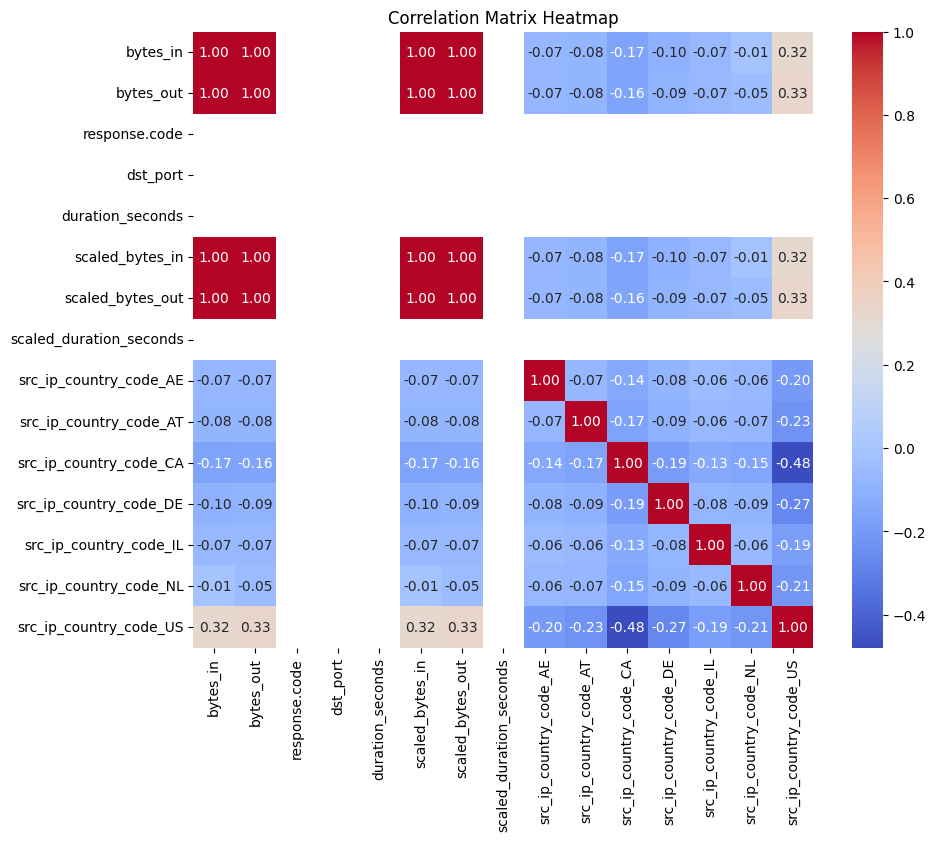

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Stacked Bar Chart for Detection Types by Country

# Preparing data for stacked bar chart

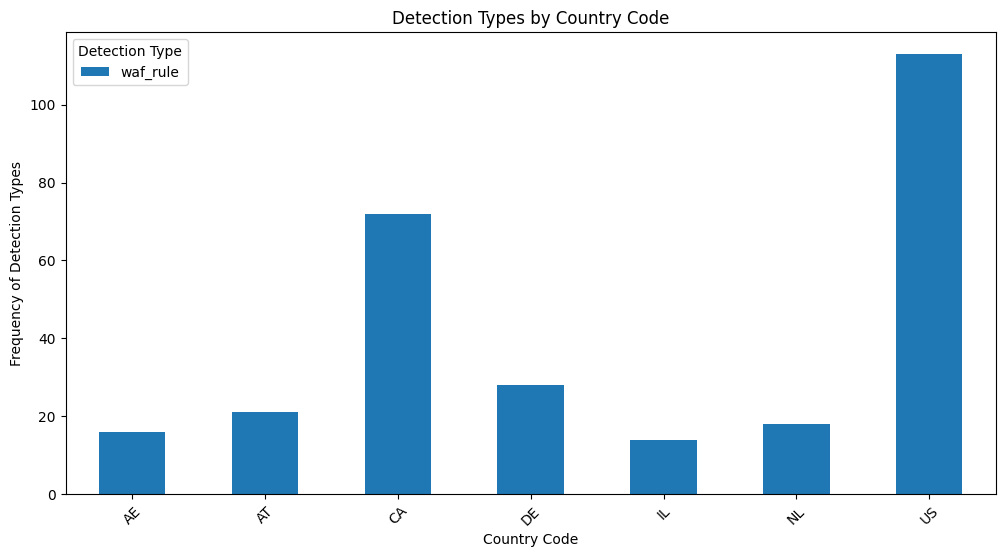

In [ ]:
detection_types_by_country = pd.crosstab(transformed_df['src_ip_country_code'], transformed_df['detection_types'])
detection_types_by_country.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency of Detection Types')
plt.xticks(rotation=45)
plt.legend(title='Detection Type')
plt.show()


# Convert 'creation_time' to datetime format

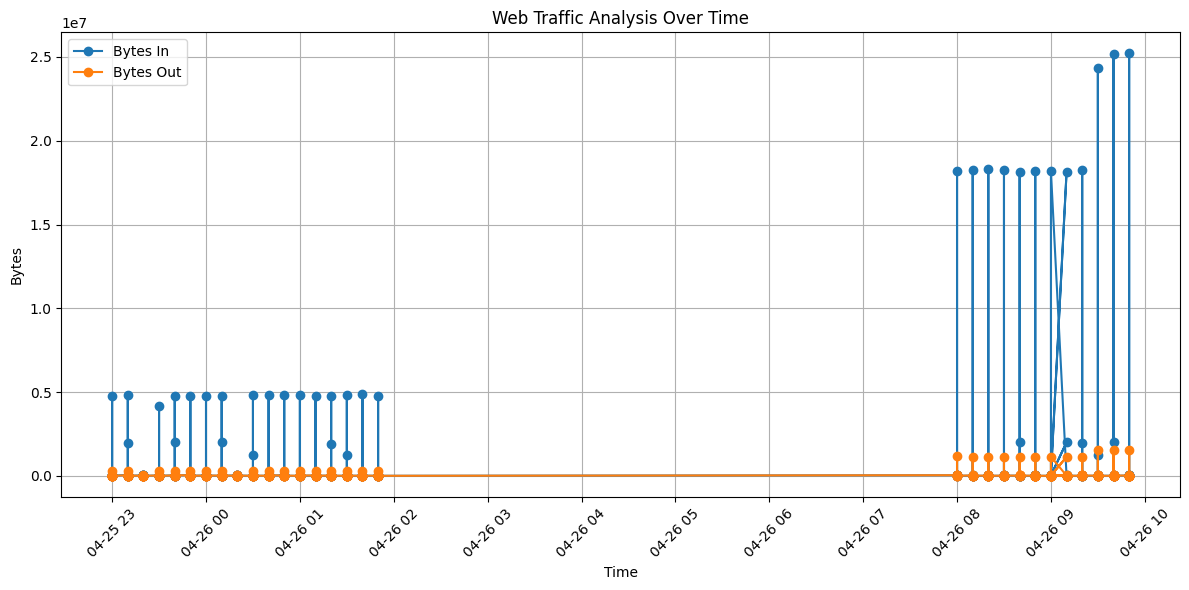

In [44]:
data['creation_time'] = pd.to_datetime(data['creation_time'])

# Set 'creation_time' as the index
data.set_index('creation_time', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['bytes_in'], label='Bytes In', marker='o')
plt.plot(data.index, data['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# Create a graph

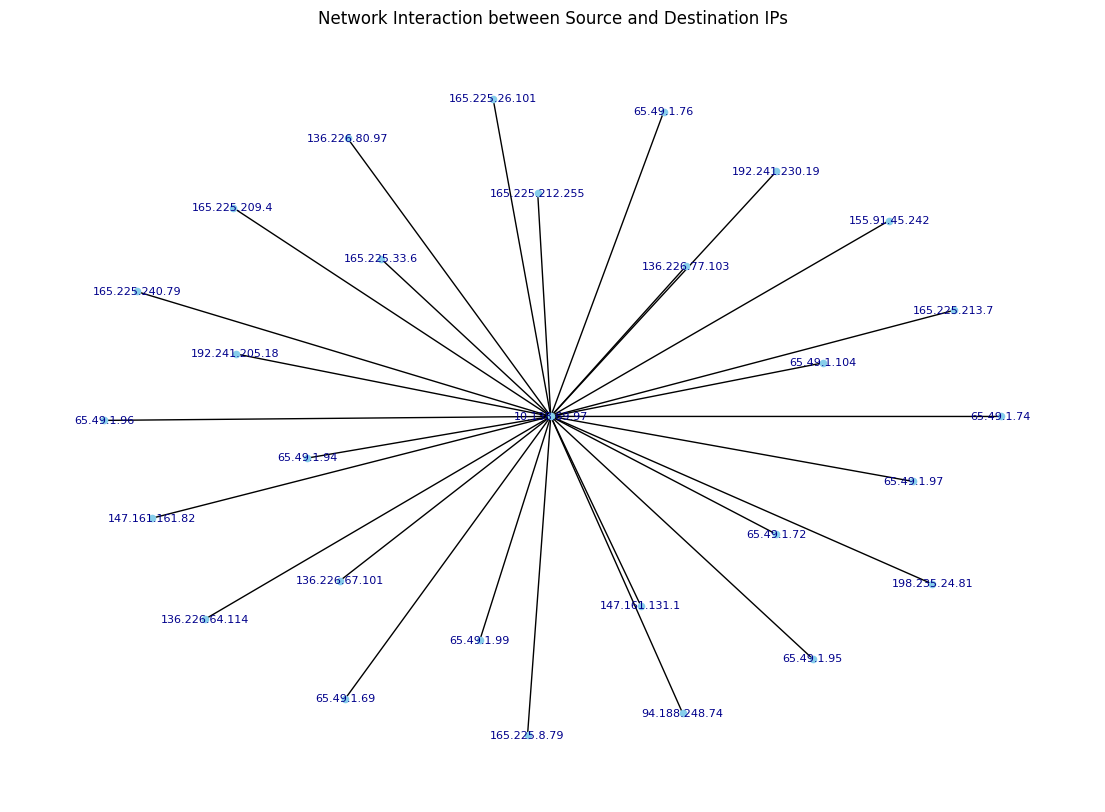

In [ ]:
G = nx.Graph()

# Add edges from source IP to destination IP
for idx, row in data.iterrows():
    G.add_edge(row['src_ip'], row['dst_ip'])

# Draw the network graph
plt.figure(figsize=(14, 10))
nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8, node_color='skyblue', font_color='darkblue')
plt.title('Network Interaction between Source and Destination IPs')
plt.axis('off')  # Turn off the axis

# Show the plot
plt.show()


# RandomForestClassifier

In [26]:
# First, encode this column into binary labels
transformed_df['is_suspicious'] = (transformed_df['detection_types'] == 'waf_rule').astype(int)

# Features and Labels
X = transformed_df[['bytes_in', 'bytes_out', 'scaled_duration_seconds']]  # Numeric features
y = transformed_df['is_suspicious']  # Binary labels

# Split the data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)

In [29]:
print("Model Accuracy: ",accuracy)

Model Accuracy:  1.0


In [30]:
print("Classification Report: ",classification)

Classification Report:                precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



# Neural Network

In [31]:
data['is_suspicious'] = (data['detection_types'] == 'waf_rule').astype(int)

# Features and labels
X = data[['bytes_in', 'bytes_out']].values  # Using only numeric features
y = data['is_suspicious'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network model
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history  = model.fit(X_train_scaled, y_train, epochs=10, batch_size=8, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9739 - loss: 0.6729
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.6239 
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.5778 
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.5068 
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.4442
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.3590
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2905
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2219
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1600
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1129
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0881 
Test Accuracy: 100.00%


# Neural network model

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6475 - loss: 0.6970 - val_accuracy: 1.0000 - val_loss: 0.6028
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9966 - loss: 0.5876 - val_accuracy: 1.0000 - val_loss: 0.5055
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.5191 - val_accuracy: 1.0000 - val_loss: 0.4187
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.4395 - val_accuracy: 1.0000 - val_loss: 0.3348
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.3480 - val_accuracy: 1.0000 - val_loss: 0.2529
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.2555 - val_accuracy: 1.0000 - val_loss: 0.1793
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.1866 - val_accuracy: 1.0000 - val_loss: 0.1201
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.1280 - val_accuracy: 1.0000 - val_loss: 0.0773


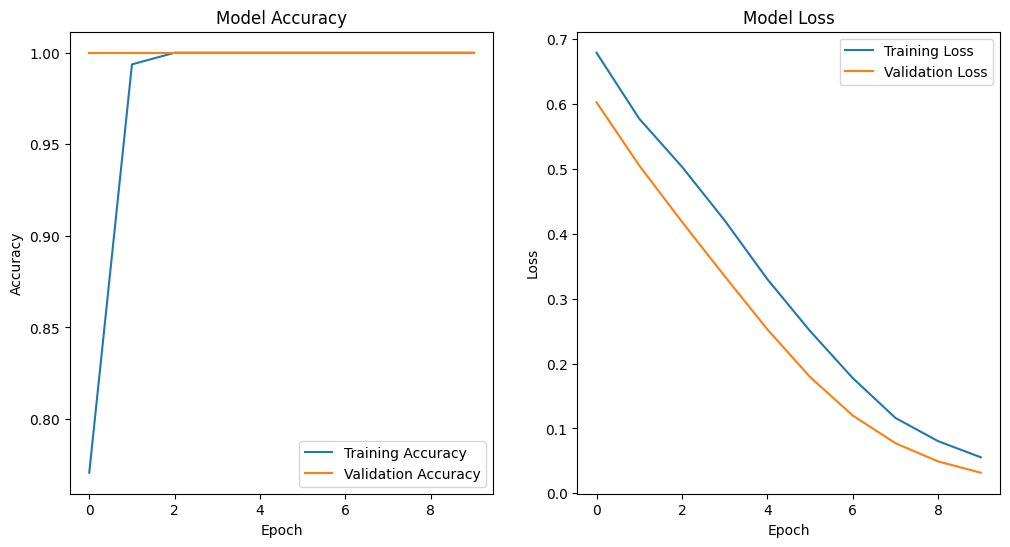

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1013 - loss: 0.7427 - val_accuracy: 0.8500 - val_loss: 0.7174
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8684 - loss: 0.6848 - val_accuracy: 0.9750 - val_loss: 0.6459
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9793 - loss: 0.6376 - val_accuracy: 1.0000 - val_loss: 0.5920
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9870 - loss: 0.5971 - val_accuracy: 1.0000 - val_loss: 0.5490
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9948 - loss: 0.5613 - val_accuracy: 1.0000 - val_loss: 0.5107
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.5295 - val_accuracy: 1.0000 - val_loss: 0.4732
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.5040 - val_accuracy: 1.0000 - val_loss: 0.4351
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.4703 - val_accuracy: 1.0000 - val_loss: 0.3954


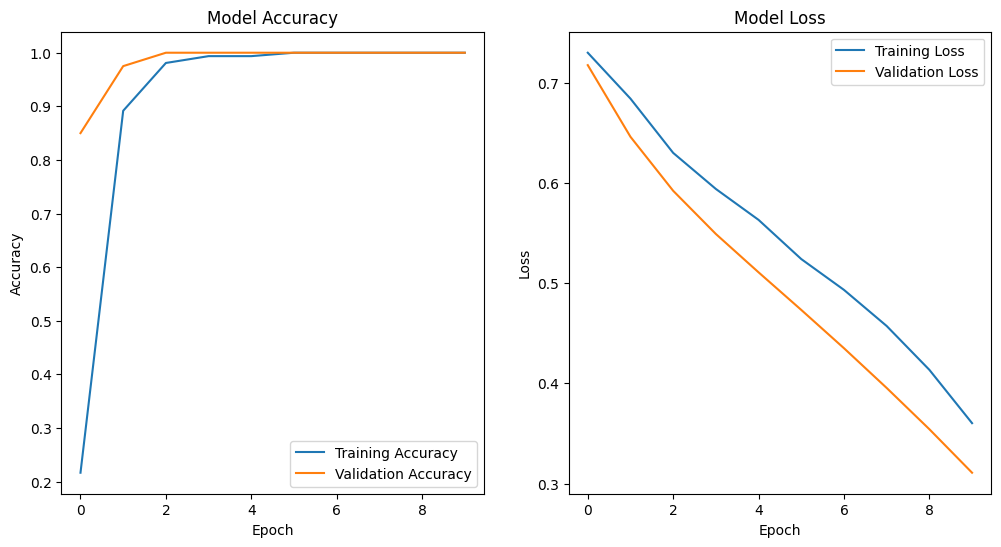

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Adjusting the network to accommodate the input size
model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()